## Ray 설치

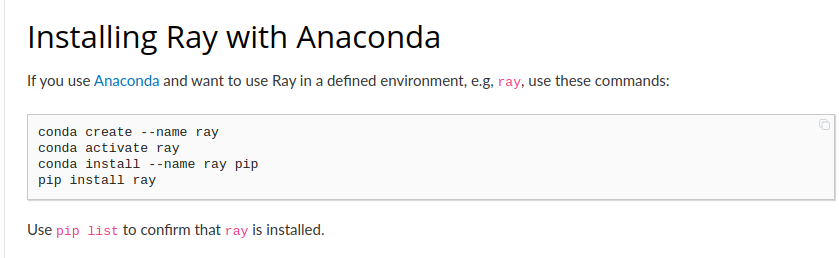

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install ray

# Ray Tutorial

#### Ray는 사용하기 위해서 import 뿐만 아니라, ray.init()이 필요합니다

Reference Link

    해당 노트북은 아래의 reference를 참고하면서 작성하였으며, 참고 링크에는 좀 더 정성적인 특징을 기술해놓았습니다.

    https://data-newbie.tistory.com/415,
    https://towardsdatascience.com/modern-parallel-and-distributed-python-a-quick-tutorial-on-ray-99f8d70369b8

In [2]:
import ray
import time
import numpy as np

ray.init()

2021-01-31 15:15:38,386	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '192.168.0.61',
 'raylet_ip_address': '192.168.0.61',
 'redis_address': '192.168.0.61:13994',
 'object_store_address': '/tmp/ray/session_2021-01-31_15-15-37_841704_91258/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-31_15-15-37_841704_91258/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-01-31_15-15-37_841704_91258',
 'metrics_export_port': 60224,
 'node_id': '96ba21a6df99efd2ffbe35bf7396bcf482f94eba'}

In [1]:
import torch

ray.init(num_cpus=4, num_gpus=2)
ray.init()

@ray.remote(num_gpus=2)
class GPUActor(object):
    def __init__(self):
        a = torch.nn.Linear(10, 10).cuda()
        b = torch.ones(1,10).cuda()
        print(a(b))

# The four tasks created here can execute concurrently.
[GPUActor.remote() for _ in range(2)]

2021-01-31 15:25:48,302	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8266


[Actor(GPUActor,df5a1a8201000000), Actor(GPUActor,cb230a5701000000)]

(pid=51645) tensor([[ 0.2239,  0.6134, -0.1355, -1.5691,  0.7666,  1.1372,  0.1896, -0.5318,
(pid=51645)           0.8081,  1.2396]], device='cuda:0', grad_fn=<AddmmBackward>)


2021-01-31 15:25:58,477	WARNING worker.py:1034 -- The actor or task with ID ffffffffffffffffcb230a5701000000 cannot be scheduled right now. It requires {CPU: 1.000000}, {GPU: 2.000000} for placement, but this node only has remaining {object_store_memory: 22.949219 GiB}, {CPU: 23.000000}, {accelerator_type:RTX: 1.000000}, {memory: 68.408203 GiB}, {node:192.168.0.61: 1.000000}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.


#### 실행 후 localhost: port번호 가 출력되는 것을 볼 수 있는데요, 이 주소는 resource가 어떤 식으로 쓰이고 있는지 보여줍니다.

#### 지금부터는 구체적인 활용법을 다루어보겠습니다.
#### 병렬처리를 하고자하는 함수를 @ray.remote라는 decoration을 통해 다음과 같이 선언합니다.

    @ray.remote
    def f(x):
        time.sleep(5)
        return x * x

    이렇게 선언하고 나면, 이제 함수는 
    
    함수명.remote()

    와 같이 .remote()를 붙여야만 호출할 수 있게 됩니다. 
    여기서, remote()는 task를 하나의 thread에 던져주는 역할을 하고, 그 메소드가 실행이 완료될 때까지 기다리지 않습니다.
    따라서 코드를 실행시켜나갈 때 remote() 가 있는 라인은 .remote()로 실행시킨 라인에서 결과를 얻지 못해도 바로 다음 줄로 넘어갑니다. 즉, 

    results = []
    for i in range(10):
        results.append(f.remote(i))

    이렇게 실행하면 함수f의 결과를 기다리지 않고, 그냥 thread에 던져놓고 바로바로 반복문을 수행하기 때문에 순식간에 10번의 loop이 끝납니다.

    ray.get(results)
    
    결과를 얻기 위해서는 ray.get()를 이용하여야 하는데요. 위와 같이 실행하면, 모든 thread의 실행이 끝났을 때 출력을 얻습니다.

In [2]:
# 병렬 처리하고 싶은 함수가 있으면, 아래의 데코레이터로 지정하면 병렬 모드로 쓸 수 있습니다. 

@ray.remote
def f(x):
    time.sleep(5)
    return x * x

In [3]:
# number of workers 변수를 통해서 위에서 선언한 함수를 몇 개를 동시에 실행시킬지 정하고 있습니다.

number_of_workers = 10

tic = time.time()
results = [f.remote(i) for i in range(number_of_workers)]
print(ray.get(results)) 


print("총 걸린 시간: ", time.time()-tic)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
총 걸린 시간:  5.247223615646362


In [4]:
number_of_workers = 40

tic = time.time()
results = [f.remote(i) for i in range(number_of_workers)]
print(ray.get(results))
print("총 걸린 시간: ", time.time()-tic)

# 원래 병렬처리가 없었다면, 40번 함수가 호출되었으므로 40*5=200 초가 걸렸겠지만, 여러 thread가 동시에 병렬 처리하여 훨씬 빠르게 수행되는 것을 확인할 수 있습니다.

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625, 676, 729, 784, 841, 900, 961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521]
총 걸린 시간:  10.179754495620728


#### 또한 Ray는 특정 데이터를 공유 메모리에 저장하고, 그 데이터를 thread 간에 공유가 가능합니다.

In [ ]:
# ray.put 함수를 이용해서 공유하고자 하는 객체를 지정할 수 있습니다.
# 이렇게 지정한 객체는 여러 함수가 접근하여 필요한 처리를 할 수 있고, 따라서 메모리를 매우 효율적으로 쓸 수 있다는 장점이 있습니다.

import numpy as np
import psutil
import scipy.signal

@ray.remote
def f(image, random_filter):
    # Do some image processing.
    return scipy.signal.convolve2d(image, random_filter)[::5, ::5]

num_of_workers = 12
filters = [np.random.normal(size=(4, 4)) for _ in range(num_of_workers)]

tic = time.time()
for _ in range(10):
    image = np.zeros((3000, 3000))
    image_id = ray.put(image)  # 공유메모리에 올리는 선언
    results = [f.remote(image_id, filters[i]) for i in range(num_of_workers)]
    ray.get(results)
print("걸린시간(s): ", time.time() - tic)

#### 시간을 비교하기 위해서 이번에는 ray 없이 for문을 수행합니다

In [ ]:
def f(image, random_filter):
    return scipy.signal.convolve2d(image, random_filter)[::5, ::5]

num_of_workers = 4
filters = [np.random.normal(size=(4, 4)) for _ in range(num_of_workers)]

tic = time.time() 
for _ in range(10):
    image = np.zeros((3000, 3000))
    results = [f(image, filters[i]) for i in range(num_of_workers)]
print("걸린시간(s): ", time.time() - tic)

#### 정확히 num_of_workes의 배수만큼 느려진 것은 아니지만 확연한 차이를 확인할 수 있는데
#### 특히 image라는 배열 변수 복제할 필요없이, 여러 thread가 ray.put() 메소드로 쉽게 공유하고 access할 수 있다는 점은 눈여겨볼 만한 포인트입니다.

In [ ]:
@ray.remote 
def create_matrix(size, num): 
    time.sleep(num) 
    return np.random.normal(size=size) 

@ray.remote 
def multiply_matrices(x, y): 
    return np.dot(x, y)

x_id = create_matrix.remote([1000, 1000], 6)
y_id = create_matrix.remote([1000, 1000], 2)
z_id = multiply_matrices.remote(x_id, y_id)

# 아래의 걸린 시간을 보면, x가 늦게 끝나므로 x가 종료되는 시점에 z가 계산됨을 알 수 있습니다. 
tic = time.time()
z = ray.get(z_id)
print("걸린시간(s): ", time.time() - tic)

#### 이번에는 다음과 같은 연산 그래프를 실현해보겠습니다. <br>
    왼쪽 그림과 오른쪽 그림의 연산 속도는 얼마나 차이가 날까요?

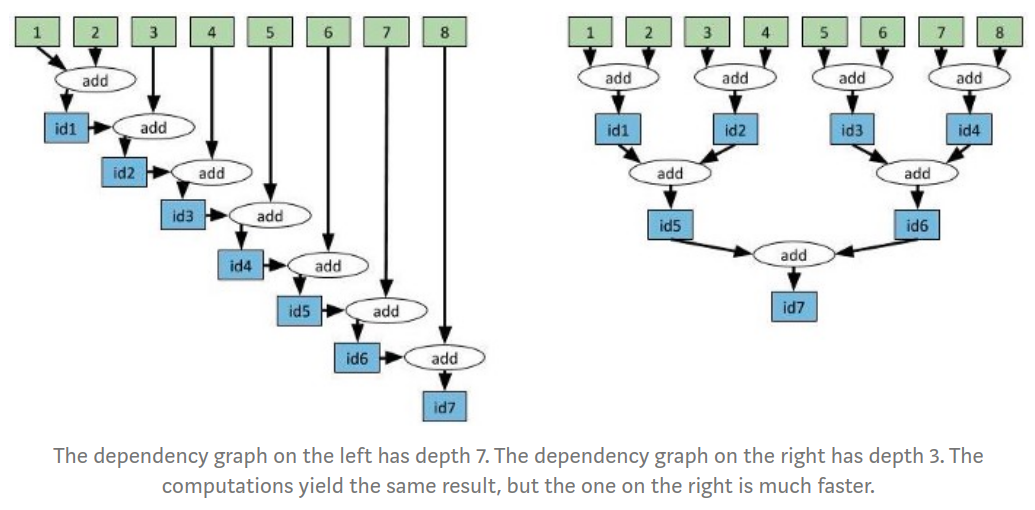

In [5]:
# 위의 그림에 있는 연산처리 순서대로 코드를 테스트 해본 것.

@ray.remote
def add(x, y):
    time.sleep(1)
    return x + y

# 먼저 왼쪽에 있는 흐름대로 add 연산을 해보겠습니다. 이 방식은 더하는 숫자가 n개 일 때, O(n)의 계산량을 필요로 합니다.
tic = time.time()
id1 = add.remote(1, 2)
id2 = add.remote(id1, 3)
id3 = add.remote(id2, 4)
id4 = add.remote(id3, 5)
id5 = add.remote(id4, 6)
id6 = add.remote(id5, 7)
id7 = add.remote(id6, 8)
result = ray.get(id7)
print("Result: ", result)
print("걸린시간(s): ", time.time() - tic)

# 먼저 왼쪽에 있는 흐름대로 add 연산을 해보겠습니다. 이 방식은 더하는 숫자가 n개 일 때, O(log(n))의 계산량이 들기 때문에,
# 위의 방법보다 n이 커질 수록 매우 유용한 방법입니다.

tic = time.time()
id1 = add.remote(1, 2)
id2 = add.remote(3, 4)
id3 = add.remote(5, 6)
id4 = add.remote(7, 8)
id5 = add.remote(id1, id2)
id6 = add.remote(id3, id4)
id7 = add.remote(id5, id6)
result = ray.get(id7)
print("Result: ", result)
print("걸린시간(s): ", time.time() - tic)

result 36
걸린시간(s):  7.171598672866821
result 36
걸린시간(s):  3.0769569873809814


아래는 위와 동일한 연산. 좀 더 간단하게 표현한 것.

In [ ]:
# 느린 것
values = [1, 2, 3, 4, 5, 6, 7, 8]
while len(values) > 1:
    values = [add.remote(values[0], values[1])] + values[2:]
result = ray.get(values[0])

# 빠른 것. 
# 코딩 요령: 리스트를 자르고, ray.remote를 리스트의 뒤로 넘긴 것.
values = [1, 2, 3, 4, 5, 6, 7, 8]
while len(values) > 1:
    values = values[2:] + [add.remote(values[0], values[1])] 
result = ray.get(values[0]) 

#### 이번에는 class를 ray를 이용하여 병렬로 처리해보겠습니다.

In [ ]:
@ray.remote
class Counter(object):
    def __init__(self):
        self.n = 0

    def increment(self, num):
        time.sleep(5)
        self.n += (num**3)
        print(self.n)

    def read(self):
        return self.n

number_of_workers = 4

tic = time.time()
counters = [Counter.remote() for i in range(number_of_workers)]
[cnt_class.increment.remote(idx) for idx, cnt_class in enumerate(counters)]
results = [c.read.remote() for c in counters]
print(ray.get(results))
print("걸린시간(s): ", time.time() - tic)

number_of_workers = 12

tic = time.time()
counters = [Counter.remote() for i in range(number_of_workers)]
[c.increment.remote(idx) for idx, c in enumerate(counters)]
results = [c.read.remote() for c in counters]
print(ray.get(results))
print("걸린시간(s): ", time.time() - tic)


#### Multiprocessing 패키지는 어떤 output이 어느 thread에서 온 것인지 확인하려면 별도의 매소드로 확인해주어야 했지만, 
#### ray는 PID를 자체적으로 함께 출력해주기 때문에 어떤 thread에서 나온 출력인지 쉽게 확인할 수 있습니다.

In [ ]:
# 메세지를 저장하고 불러오는 class를 선언
@ray.remote
class MessageActor(object):
    def __init__(self):
        self.messages = []
    
    def add_message(self, message):
        self.messages.append(message)
        
    def get_and_clear_messages(self):
        messages = self.messages
#         time.sleep(0.2)
        self.messages = []
        return messages

# worker라는 함수는 메세지를 받아서 저장해주는 역할을 합니다.
@ray.remote
def worker(message_actor, j):
    for i in range(100):
        time.sleep(np.random.uniform(0.5, 1)) # 의도적으로 random 하게 시간을 기다리게 하여, 각 worker가 서로 다른 시간에 랜덤하게 message_actor에 접근하도록 해보았습니다.
        message_actor.add_message.remote("Message {} from worker {}.".format(i, j))
        
# 메세지 class 의 인스턴스 생성
message_actor = MessageActor.remote()

# 위에서 생성한 클레스에 10개의 병렬 worker를 할당해보겠습니다.
# 각 worker는 1개의 클래스 메서드(여기서는 message_actor의 add_message 메서드)를 실행하여 self.messages에 메세지를 계속 append합니다. 
num_of_workers = 10
[worker.remote(message_actor, j) for j in range(num_of_workers)]

# for문을 돌면서 계속해서 massage를 가져옵니다.
for _ in range(100):
    # 아래줄 처럼 실행하면 에러가 납니다. 그 이유는 @ray.remote 로 decorate이 되었으면 메소드를 실행할 때, .remote()를 뒤에 붙여야하기 때문입니다.
    # new_messages = message_actor.get_and_clear_messages()
    # 
    # 올바른 예시
    new_messages = ray.get(message_actor.get_and_clear_messages.remote())
    print("New messages:", new_messages)
    time.sleep(1)

# 위의 명령어를 실행하면 다음과 비슷한 출력이 나옵니다.
# New messages: []
# New messages: ['Message 0 from worker 1.', 'Message 0 from worker 0.']
# New messages: ['Message 0 from worker 2.', 'Message 1 from worker 1.', 'Message 1 from worker 0.', 'Message 1 from worker 2.']
# New messages: ['Message 2 from worker 1.', 'Message 2 from worker 0.', 'Message 2 from worker 2.']
# New messages: ['Message 3 from worker 2.', 'Message 3 from worker 1.', 'Message 3 from worker 0.']
# New messages: ['Message 4 from worker 2.', 'Message 4 from worker 0.', 'Message 4 from worker 1.']
# New messages: ['Message 5 from worker 2.', 'Message 5 from worker 0.', 'Message 5 from worker 1.']

#### 위 코드를 통해, ray를 이용하여 분산 RL을 구현해본다고 했을 때 다음을 생각해볼 수 있습니다. 

    위에서 class는 두 가지 메소드를 가진다.

    1) add_message와 2) get_and_clear_messages 로써 2개.
    
    한편, worker 함수는 message_actor라는 클래스의 add_message 메소드를 실행하는 함수이며, 계속해서 self.messege라는 클래스 변수를 변동시켰다.

    그리고 코드 아래 부분에서는 self.messege라는 변수에 새로운 메세지를 append하는 작업이 계속 되고 있으면서 동시에, 

    클래스의 다른 메소드인 get_and_clear_messages를 실행하였다. 즉 다시말해서 다른 함수가 계속해서 새로운 '쓰기'작업을 하는 중에 이와는 또 다른 함수가 똑같은 변수에 접근하여 '읽기'를 수행할 수 있는 것.

    이는 바로, 강화학습의 Q-learning 기법에서 많이 쓰이는 Replay Buffer를 여러 agent가 공유하고, 쓰기와 읽기를 동시에 할 수 있음을 시사한다.

    클래스의 다른 메소드를 동시에 실행하는 것까지는 놀라운 일이 아닐지라도,

    self.messege 라는 변수를 서로 다른 함수끼리 공유하면서 지속적으로 append하고 accessing하는 것을 실시간으로, 비교적 간단한 문법으로 가능하다는 것은 큰 장점이라고 볼 수 있다.

In [ ]:
import numpy as np
from collections import defaultdict

num_of_workers = 4

@ray.remote
class StreamingPrefixCount(object):
    def __init__(self):
        self.prefix_count = defaultdict(int)
        self.popular_prefixes = set()

    def add_document(self, document):
        for word in document:
            for i in range(1, len(word)):
                prefix = word[:i]
                self.prefix_count[prefix] += 1
                if self.prefix_count[prefix] > 3:
                    self.popular_prefixes.add(prefix)

    def get_popular(self):
        return self.popular_prefixes

streaming_actors = [StreamingPrefixCount.remote() for _ in range(num_of_workers)]

tic = time.time()
for i in range(num_of_workers * 10):
    document = [np.random.bytes(20) for _ in range(30000)]
    streaming_actors[i % num_of_workers].add_document.remote(document)

results = ray.get([actor.get_popular.remote() for actor in streaming_actors])
popular_prefixes = set()
for prefixes in results:
    popular_prefixes |= prefixes
print("걸린시간(s): ", time.time() - tic)
print(popular_prefixes)

In [ ]:
from collections import defaultdict

num_of_workers = 4

class StreamingPrefixCount(object):
    def __init__(self):
        self.prefix_count = defaultdict(int)
        self.popular_prefixes = set()

    def add_document(self, document):
        for word in document:
            for i in range(1, len(word)):
                prefix = word[:i]
                self.prefix_count[prefix] += 1
                if self.prefix_count[prefix] > 3:
                    self.popular_prefixes.add(prefix)

    def get_popular(self):
        return self.popular_prefixes

streaming_actors = [StreamingPrefixCount() for _ in range(num_of_workers)]

tic = time.time()
for i in range(num_of_workers * 10):
    document = [np.random.bytes(20) for _ in range(30000)]
    streaming_actors[i % num_of_workers].add_document(document)

results = [actor.get_popular() for actor in streaming_actors]
popular_prefixes = set()
for prefixes in results:
    popular_prefixes |= prefixes
print("걸린시간(s): ", time.time() - tic)
print(popular_prefixes)

#### 딥러닝 모델의 평가도 Ray로 할 수 있다.

In [ ]:
import psutil
import ray
import sys
import tensorflow as tf

num_cpus = psutil.cpu_count(logical=False)
ray.init(num_cpus=num_cpus)
filename = '/tmp/model'

@ray.remote
class Model(object):
    def __init__(self, i):
        # Pin the actor to a specific core if we are on Linux to prevent
        # contention between the different actors since TensorFlow uses
        # multiple threads.
        if sys.platform == 'linux':
            psutil.Process().cpu_affinity([i])
        # Load the model and some data.
        self.model = tf.keras.models.load_model(filename)
        mnist = tf.keras.datasets.mnist.load_data()
        self.x_test = mnist[1][0] / 255.0

    def evaluate_next_batch(self):
        # Note that we reuse the same data over and over, but in a
        # real application, the data would be different each time.
        return self.model.predict(self.x_test)

actors = [Model.remote(i) for i in range(num_cpus)]

# Parallelize the evaluation of some test data.
for j in range(10):
    results = ray.get([actor.evaluate_next_batch.remote() for actor in actors])


#### 특징
    
    위의 for문을 보면, actor가 총 10번 선언이 되는 것을 볼 수 있습니다. 일반적인 상황이라면 10번 model을 load했을텐데,
    Ray는 액터의 생성자에서 모델을 한 번만 로드하여 이 모델을 actor끼리 공유합니다.

In [ ]:
# Python 기본 패키지인 multiprocessing 패키지를 이용한 것

from multiprocessing import Pool
import psutil
import sys
import tensorflow as tf

num_cpus = psutil.cpu_count(logical=False)

filename = '/tmp/model'

def evaluate_next_batch(i):
    # Pin the process to a specific core if we are on Linux to prevent
    # contention between the different processes since TensorFlow uses
    # multiple threads.
    if sys.platform == 'linux':
        psutil.Process().cpu_affinity([i])
    model = tf.keras.models.load_model(filename)
    mnist = tf.keras.datasets.mnist.load_data()
    x_test = mnist[1][0] / 255.0
    return model.predict(x_test)

pool = Pool(num_cpus)

for _ in range(10):
    pool.map(evaluate_next_batch, range(num_cpus))